In [22]:
import flow_matching
import numpy as np
import torch
import matplotlib.pyplot as plt
from flow_matching.path.scheduler import CondOTScheduler, CosineScheduler, VPScheduler, PolynomialConvexScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
import time
from torch import nn, Tensor

In [9]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 1, time_dim: int = 1, hidden_dim: int = 128, num_layers: int = 4):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.layer_norm = nn.LayerNorm(input_dim)

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    Swish(),
                ) for _ in range(num_layers - 2)
            ],
            nn.Linear(hidden_dim, input_dim),
        )
    
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        # x = self.layer_norm(x)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

(737103,)


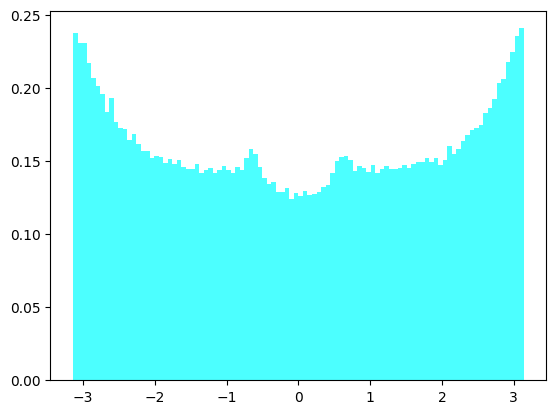

In [10]:
realistic_dataset = np.load("deltaphimoredata.npy")
dphi = realistic_dataset[:, 2]
print(dphi.shape)

plt.hist(dphi, bins=100, density=True, alpha=0.7, color='cyan')
plt.show()

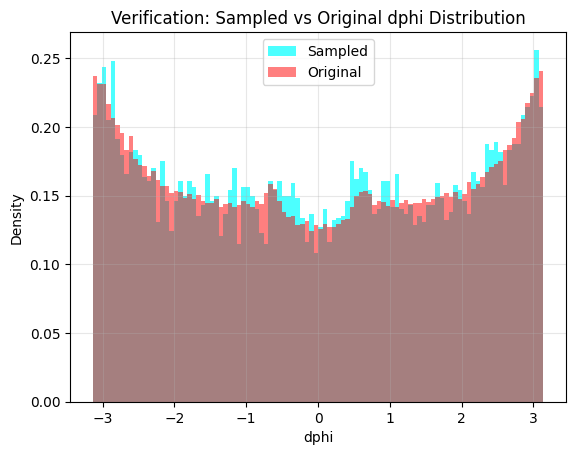

In [11]:
# Create a custom sampler for dphi distribution
dphi_tensor = torch.from_numpy(dphi).float()

def sample_dphi(n_samples):
    """Sample from dphi distribution by randomly selecting from the dataset"""
    indices = torch.randint(0, len(dphi_tensor), (n_samples,))
    return dphi_tensor[indices]

# Test sampling
test_samples = sample_dphi(10000) # sample 10,000 points from dphi distribution randomly
plt.hist(test_samples.numpy(), bins=100, density=True, alpha=0.7, color='cyan', label='Sampled')
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Original')
plt.title('Verification: Sampled vs Original dphi Distribution', fontsize=12)
plt.xlabel('dphi')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

t random tra 0 e 1

In [5]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        #t = torch.linspace(0, 1, batch_curr).to(device) # time sampling linearly from [0, 1] (discrete)
        t = torch.rand(batch_curr).to(device) # time sampling randomly from [0, 1] (continuous)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

Using device: cuda
Experiment 4 Model Parameters: 66563


KeyboardInterrupt: 

In [ ]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

In [ ]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

t linspace from 0 to 1 (shape = batchsize)

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 689.83 ms/step | loss    5.479
| iter     10 | 6384.54 ms/step | loss    5.167
| iter     20 | 6179.69 ms/step | loss    4.986
| iter     30 | 5956.83 ms/step | loss    4.977
| iter     40 | 6381.05 ms/step | loss    5.002
| iter     50 | 6224.40 ms/step | loss    4.984
| iter     60 | 6120.17 ms/step | loss    5.055
| iter     70 | 5910.38 ms/step | loss    4.970
| iter     80 | 6130.70 ms/step | loss    5.036
| iter     90 | 6450.42 ms/step | loss    5.020
| iter    100 | 5991.19 ms/step | loss    4.967

Experiment 4 training complete!
Total iterations: 3636


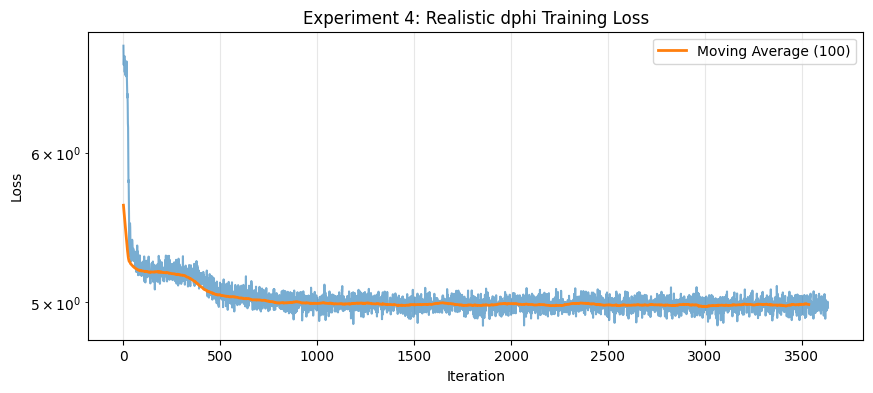

In [32]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        t = torch.linspace(0, 1, batch_curr).to(device) # time sampling linearly from [0, 1] (discrete)
        # t = torch.rand(batch_curr).to(device) # time sampling randomly from [0, 1] (continuous)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

In [33]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

Generated trajectories shape: (200, 100000)


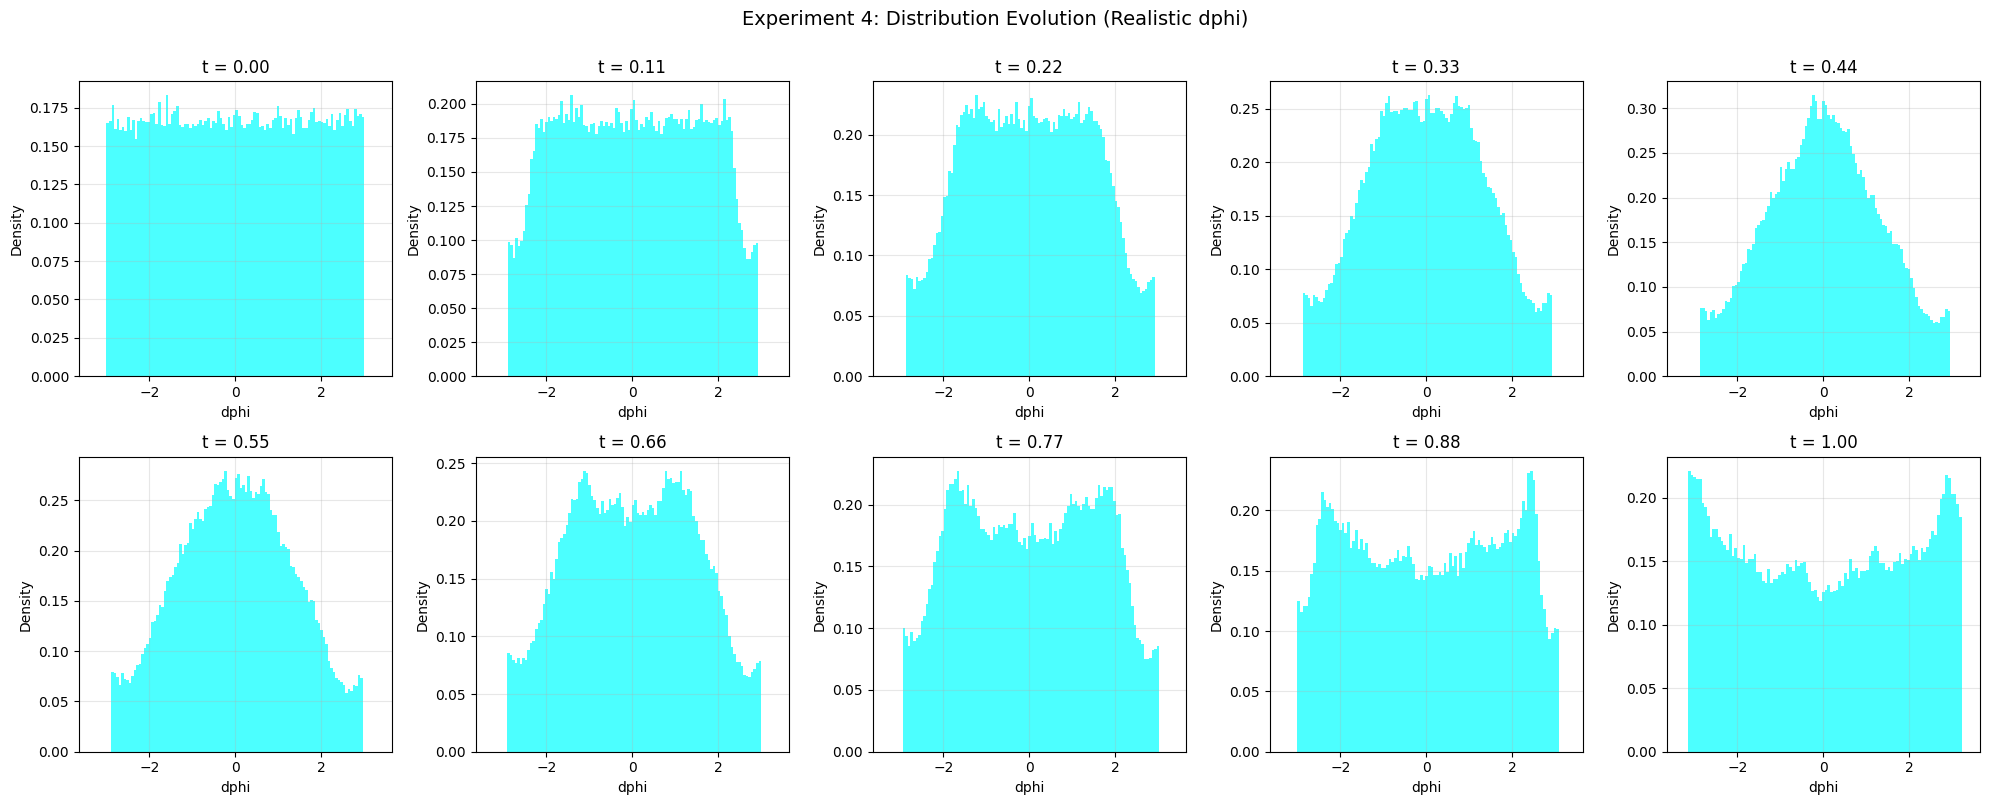

In [34]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

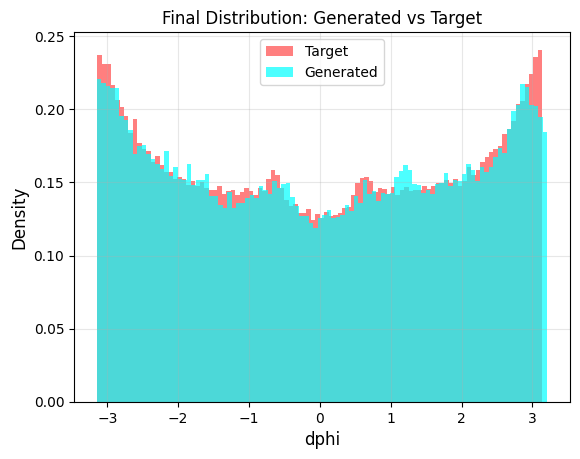

In [35]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

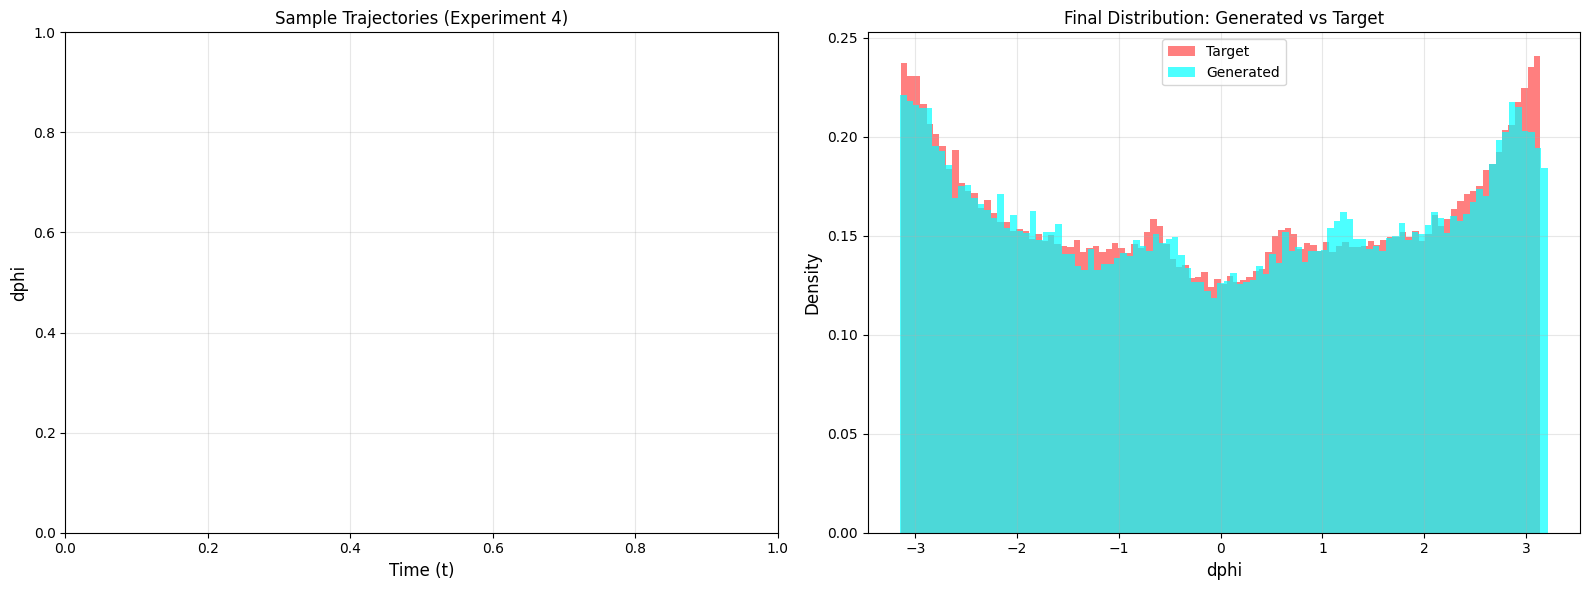

In [36]:
# Visualize individual trajectories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# n_trajectory_samples = 100000
# Plot sample trajectories
# for i in range(min(n_trajectory_samples, n_samples)):
#     axes[0].plot(T.cpu().numpy(), sol_exp4[:, i], alpha=0.1, color='cyan', linewidth=0.5)

axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('dphi', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 4)', fontsize=12)
axes[0].grid(alpha=0.3)

# Show distribution of final positions
final_positions_exp4 = sol_exp4[-1, :]
axes[1].hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
axes[1].hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
axes[1].set_xlabel('dphi', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Final Distribution: Generated vs Target', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

t campionato random nell'array linspace tra 0 e 1 con 100 step

In [ ]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

time_tensor = torch.linspace(0, 1, 101)
#print(time_tensor)

for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        
        indices = torch.randint(0, len(time_tensor), (batch_curr,))
        t = time_tensor[indices]
        #print(t)
        t = t.to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 652.96 ms/step | loss    5.357
| iter     10 | 6341.48 ms/step | loss    5.115
| iter     20 | 6189.73 ms/step | loss    5.038
| iter     30 | 6340.94 ms/step | loss    4.905
| iter     40 | 6066.73 ms/step | loss    4.911
| iter     50 | 6356.57 ms/step | loss    4.956
| iter     60 | 6135.06 ms/step | loss    4.985
| iter     70 | 6385.77 ms/step | loss    4.974
| iter     80 | 6336.72 ms/step | loss    4.940
| iter     90 | 6324.17 ms/step | loss    4.940
| iter    100 | 6183.37 ms/step | loss    5.026

Experiment 4 training complete!


In [ ]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

Generated trajectories shape: (200, 100000)


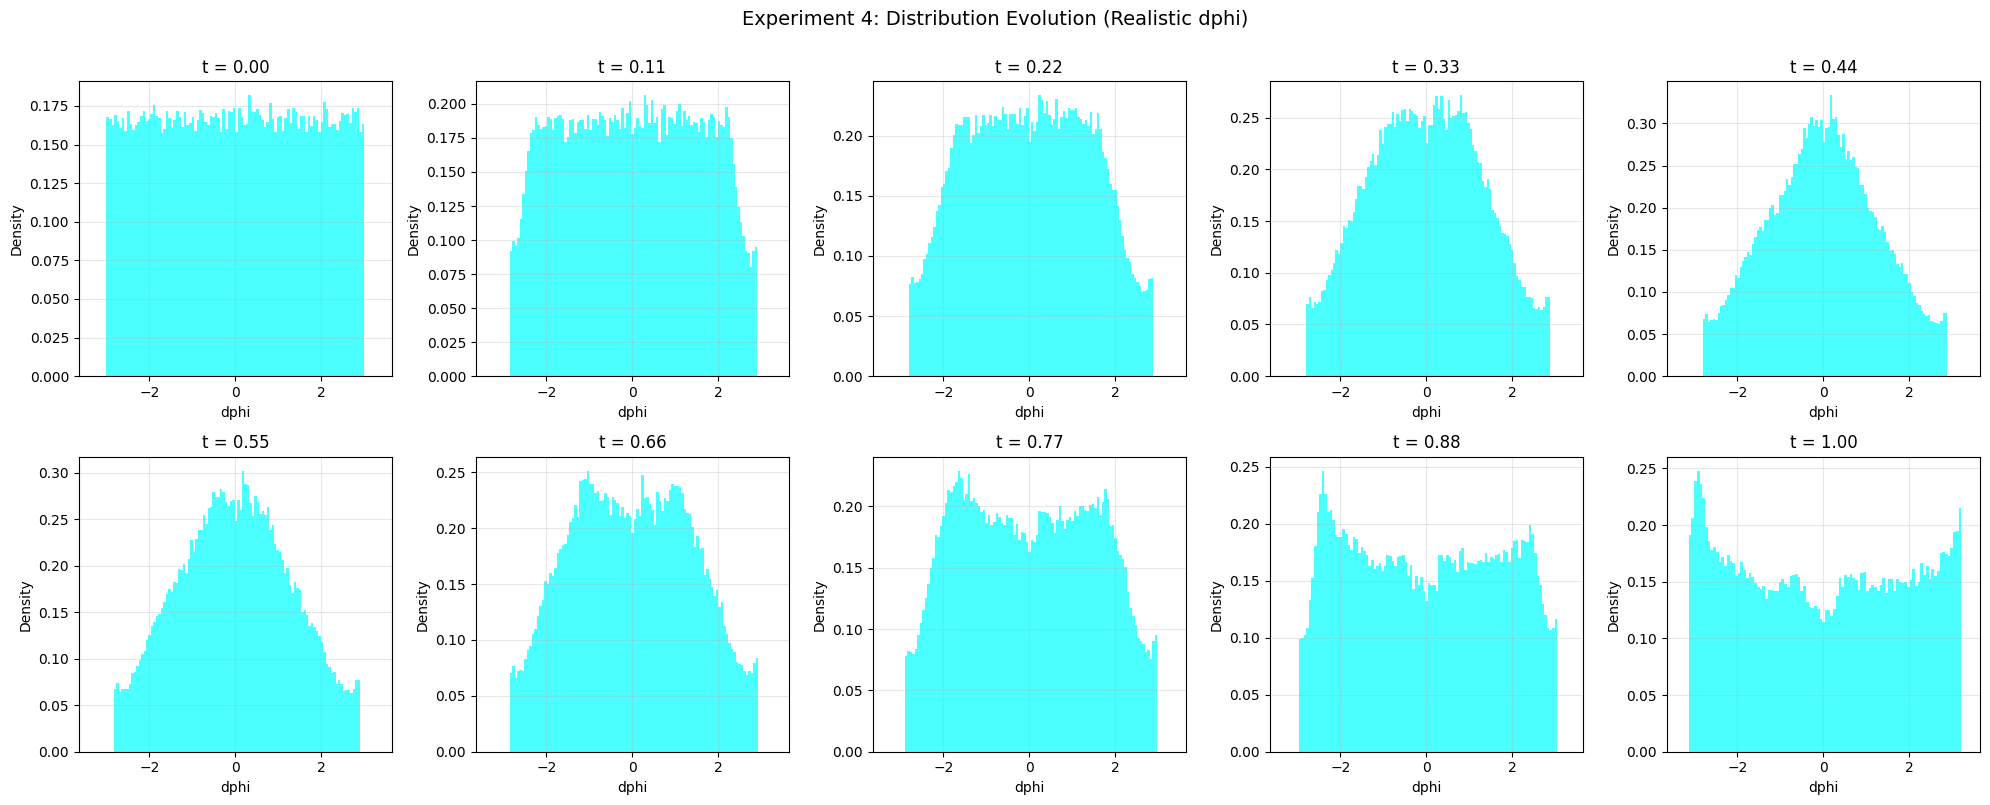

In [30]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

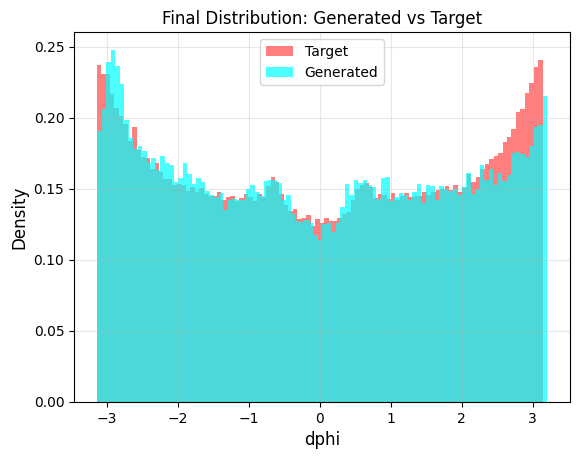

In [31]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

t campionato randomicamente in un array costruito precedentemente in modo che i tempi siano equispaziati ma più fitti al centro (tra 0.4 e 0.6) rispetto all'esterno.

In [ ]:
time_tensor1 = torch.linspace(0, 0.39, 40)
time_tensor2 = torch.linspace(0.4, 0.6, 101)
time_tensor3 = torch.linspace(0.61, 1.0, 40)
time_tensor = torch.cat([time_tensor1, time_tensor2, time_tensor3], dim=0)

indices = torch.randint(0, len(time_tensor), (10000,))
t = time_tensor[indices]

plt.hist(t.numpy(), bins=100, range=(0,1), density=True, color='orange', alpha=0.7)
plt.title(f"Normal distribution clamped")
plt.show()

Using device: cuda
Experiment 4 Model Parameters: 66563
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4020, 0.4040, 0.4060, 0.4080,
        0.4100, 0.4120, 0.4140, 0.4160, 0.4180, 0.4200, 0.4220, 0.4240, 0.4260,
        0.4280, 0.4300, 0.4320, 0.4340, 0.4360, 0.4380, 0.4400, 0.4420, 0.4440,
        0.4460, 0.4480, 0.4500, 0.4520, 0.4540, 0.4560, 0.4580, 0.4600, 0.4620,
        0.4640, 0.4660, 0.4680, 0.4700, 0.4720, 0.4740, 0.4760, 0.4780, 0.4800,
        0.4820, 0.4840, 0.4860, 0.4880, 0.4900, 0.4920, 0.4940, 0.4960, 0.4980,
        0.5000, 0.5020, 0.5040, 0.5060, 0.5080, 0.5100, 0.5120, 0.5140, 0.5160,
        0.5180, 0.5200, 0.5220, 0.5240, 0.5260, 0.5280, 0.5300, 

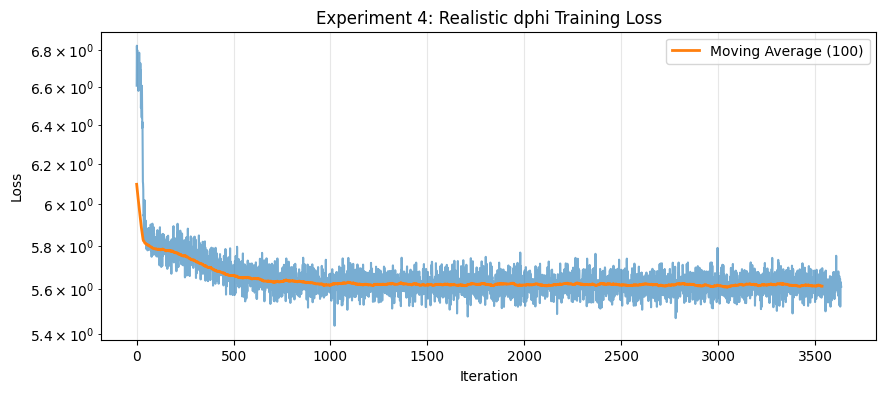

In [8]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

time_tensor1 = torch.linspace(0, 0.39, 40)
time_tensor2 = torch.linspace(0.4, 0.6, 101)
time_tensor3 = torch.linspace(0.61, 1.0, 40)
time_tensor = torch.cat([time_tensor1, time_tensor2, time_tensor3], dim=0)
# print(time_tensor)

for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        
        indices = torch.randint(0, len(time_tensor), (batch_curr,))
        t = time_tensor[indices]
        #print(t)
        t = t.to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

In [9]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

Generated trajectories shape: (200, 100000)


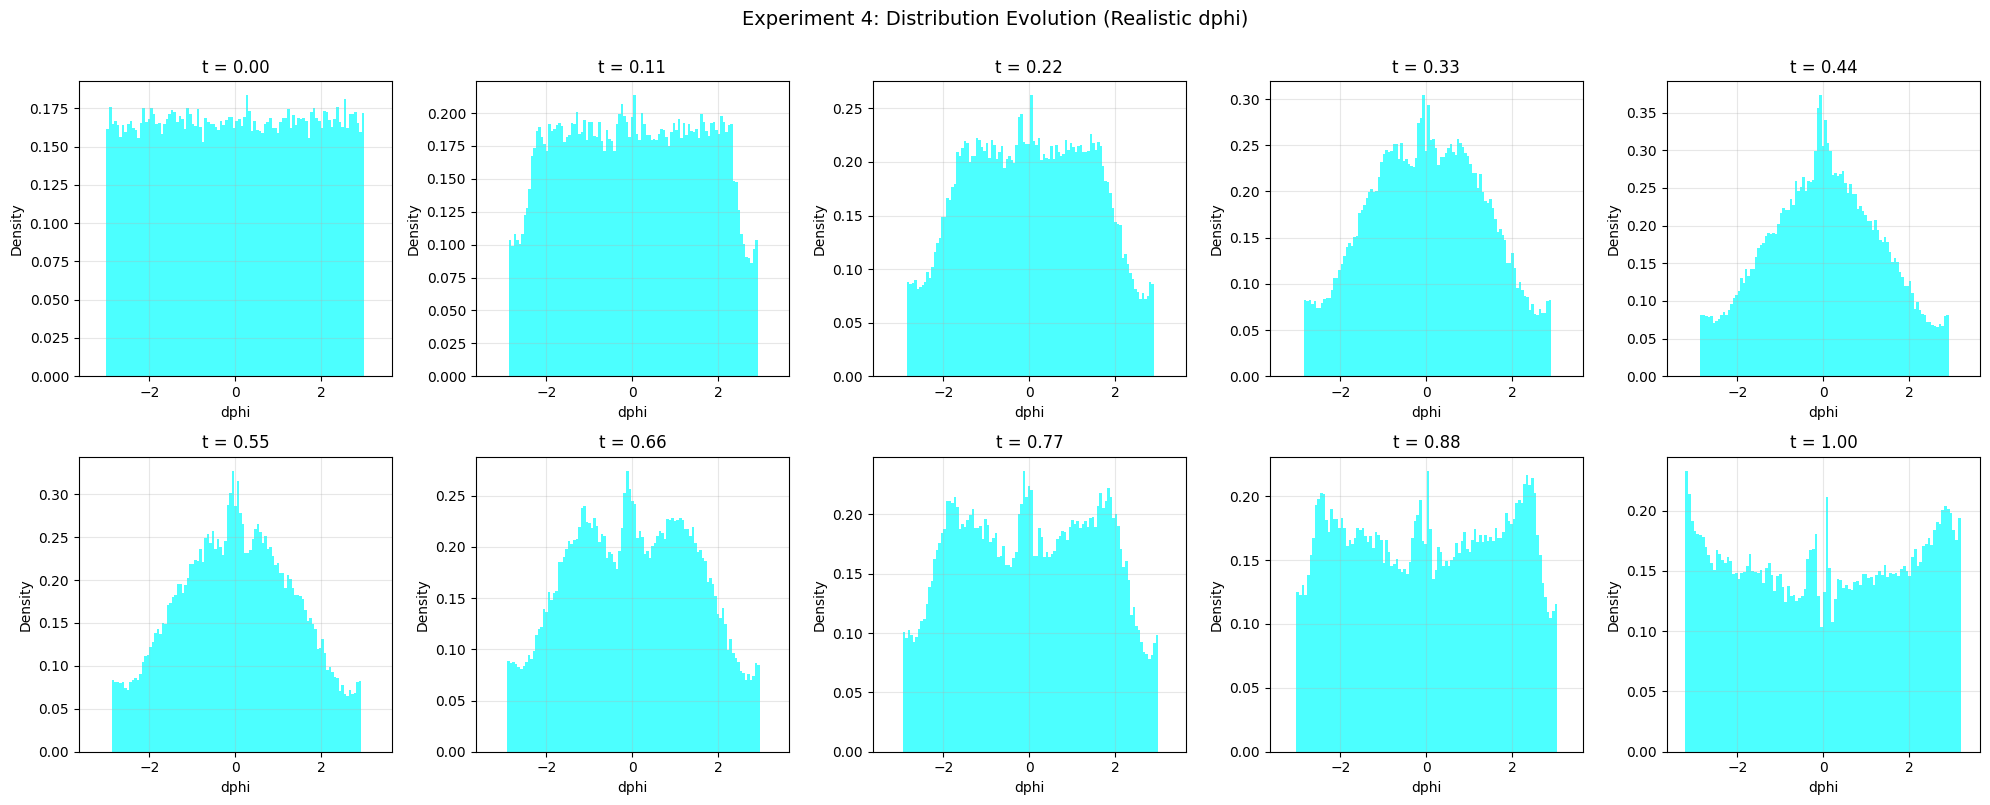

In [10]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

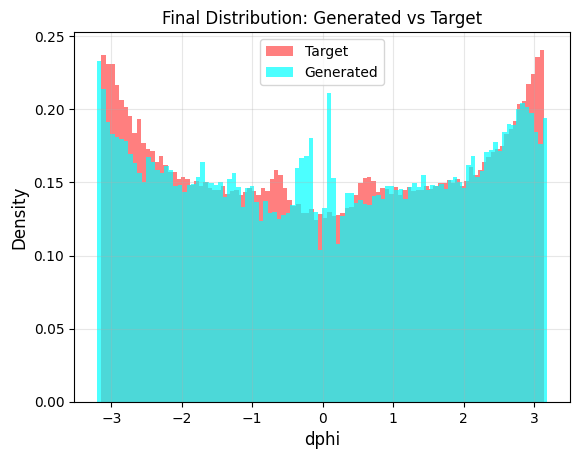

In [11]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

t random tra 0 e 1 ma con campionamento maggiore al centro

In [ ]:
t = torch.randn(10000) * 0.25 + 0.5
t = torch.clamp(t, 0.0, 1.0)

plt.hist(t.numpy(), bins=100, range=(0,1), density=True, color='orange', alpha=0.7)
plt.title(f"Normal distribution clamped")
plt.show()

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 706.49 ms/step | loss    5.905
| iter     10 | 6135.62 ms/step | loss    5.460
| iter     20 | 6159.72 ms/step | loss    5.391
| iter     30 | 6381.92 ms/step | loss    5.402
| iter     40 | 5839.24 ms/step | loss    5.377
| iter     50 | 6211.88 ms/step | loss    5.358
| iter     60 | 6108.35 ms/step | loss    5.391
| iter     70 | 5963.42 ms/step | loss    5.404
| iter     80 | 6169.26 ms/step | loss    5.313
| iter     90 | 5929.95 ms/step | loss    5.373
| iter    100 | 6193.77 ms/step | loss    5.355

Experiment 4 training complete!
Total iterations: 3636


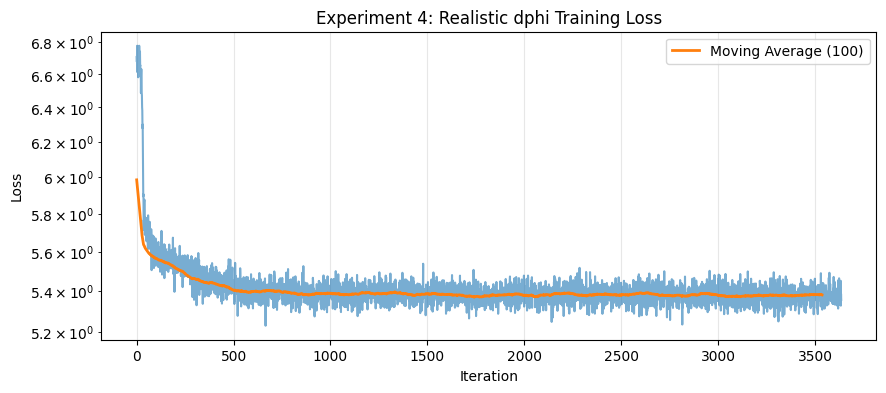

In [ ]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        
        t = torch.randn(batch_curr) * 0.25 + 0.5
        t = torch.clamp(t, 0.0, 1.0)
        t = t.to(device)

        # # Conta quanti valori sono esattamente 0 o 1
        # n_zeros = (t == 0.0).sum().item()
        # n_ones = (t == 1.0).sum().item()

        # print(f"Numero di 0.0 (valori clampati al minimo): {n_zeros}")
        # print(f"Numero di 1.0 (valori clampati al massimo): {n_ones}")
        # print(f"Percentuale di valori 'bordo': {(n_zeros + n_ones) / batch_curr * 100:.2f}%")
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

In [11]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

Generated trajectories shape: (200, 100000)


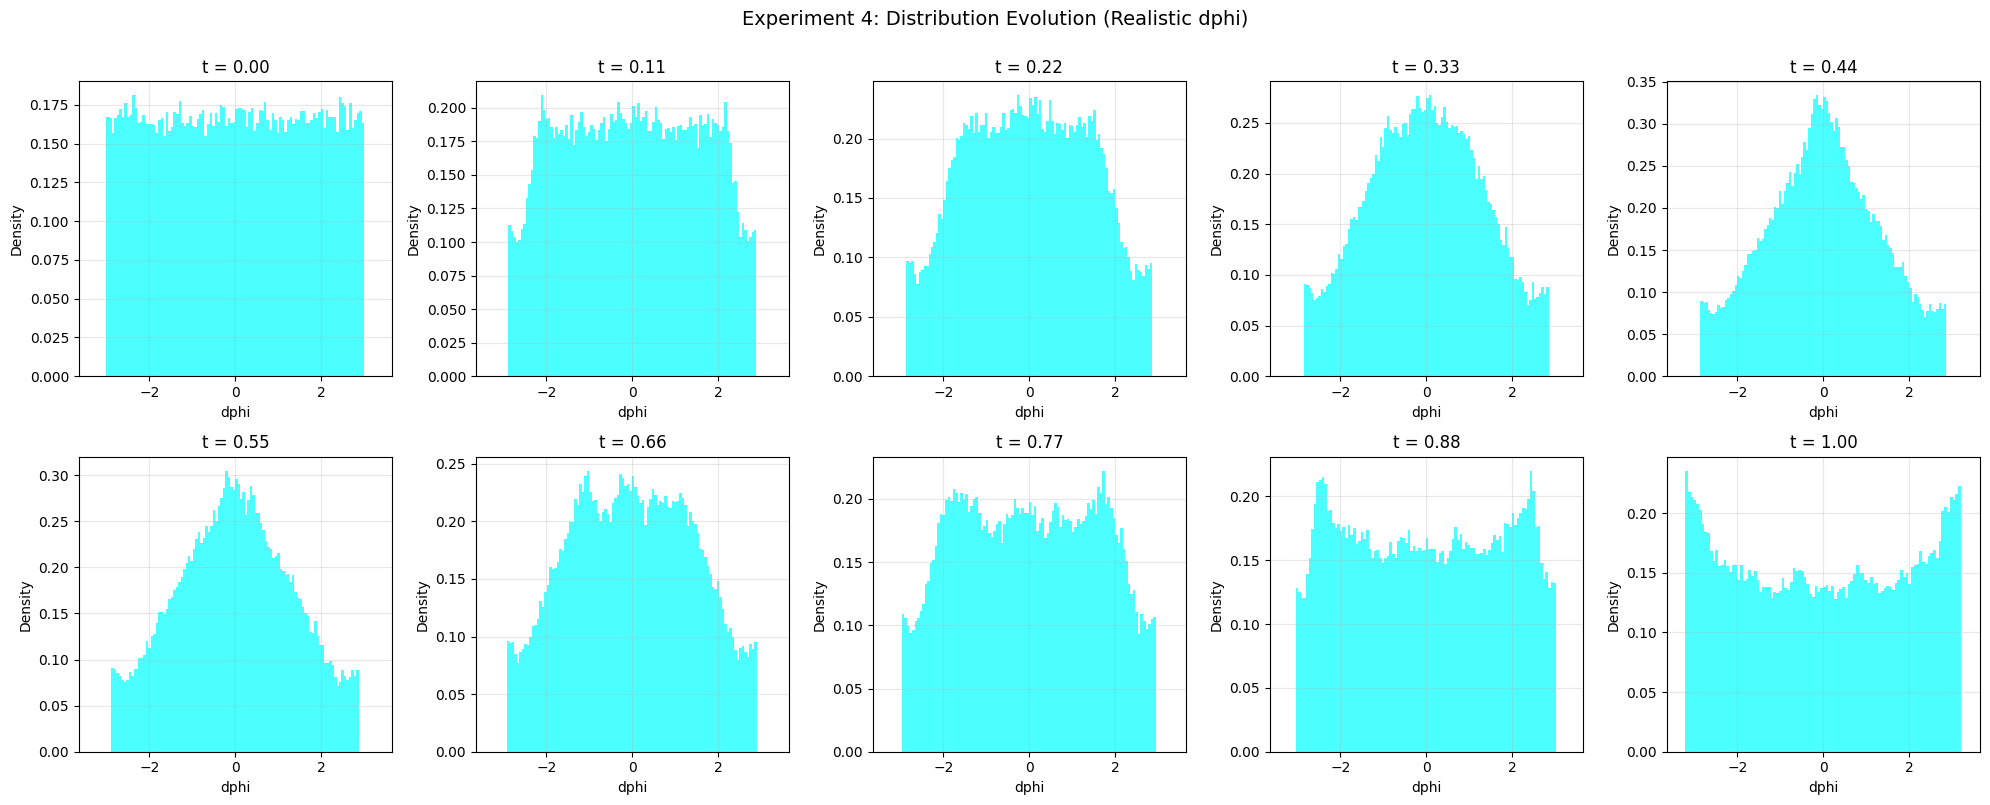

In [14]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

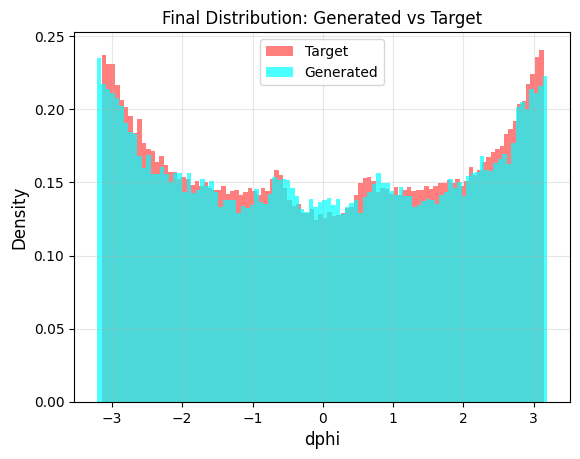

In [15]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

proviamo con la distribuzione beta

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 648.99 ms/step | loss    5.130
| iter     10 | 5977.43 ms/step | loss    5.008
| iter     20 | 6017.34 ms/step | loss    4.818
| iter     30 | 6012.19 ms/step | loss    4.825
| iter     40 | 5967.05 ms/step | loss    4.738
| iter     50 | 5918.57 ms/step | loss    4.866
| iter     60 | 5888.26 ms/step | loss    4.854
| iter     70 | 5939.50 ms/step | loss    4.845
| iter     80 | 5867.48 ms/step | loss    4.878
| iter     90 | 5892.40 ms/step | loss    4.875
| iter    100 | 5946.62 ms/step | loss    4.839

Experiment 4 training complete!
Total iterations: 3636


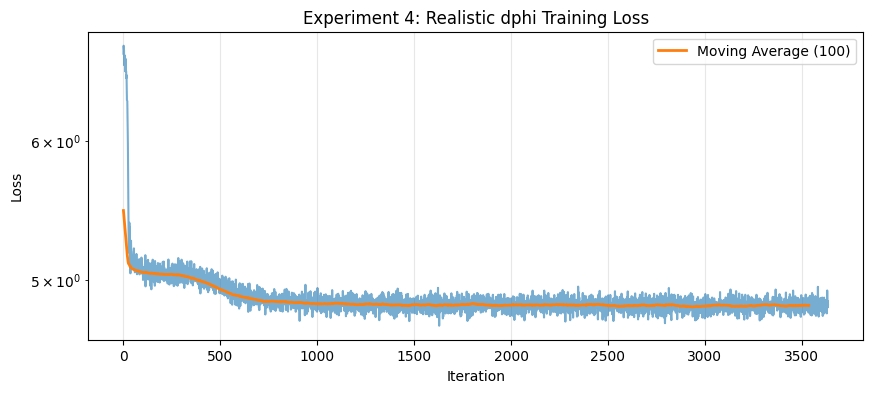

In [8]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

alpha_val = 0.8
beta_val = 0.8

dist = torch.distributions.Beta(alpha_val, beta_val)

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)

        t = dist.sample((batch_curr,))

        t = t.to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

Generated trajectories shape: (200, 100000)


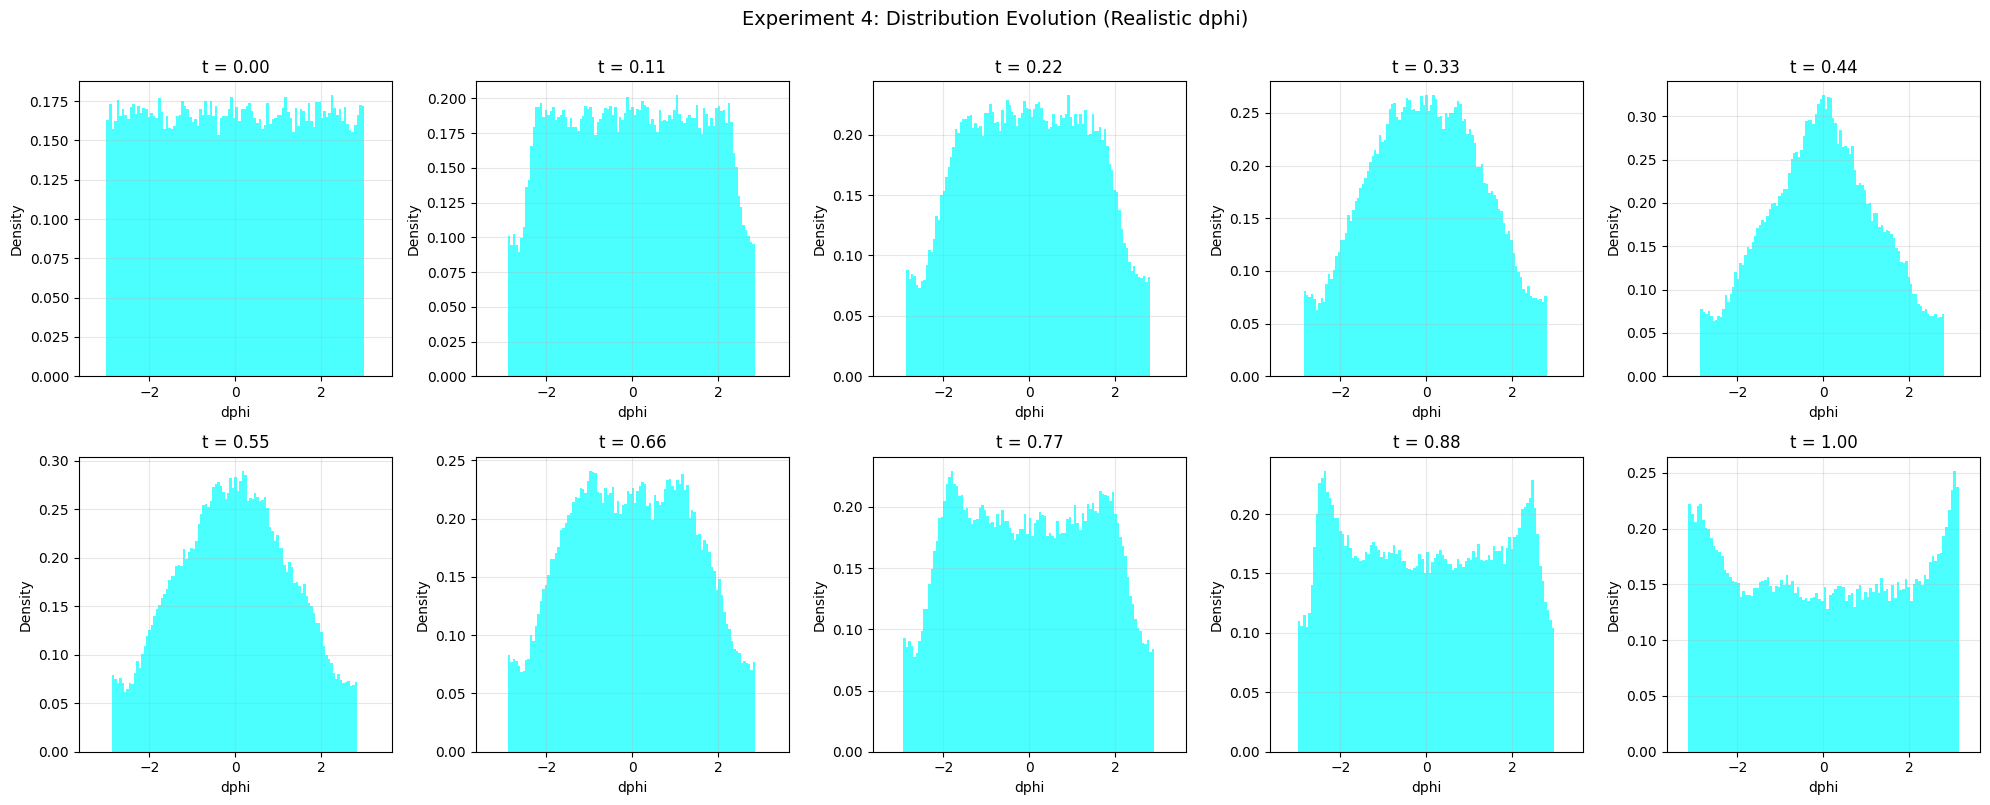

In [9]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

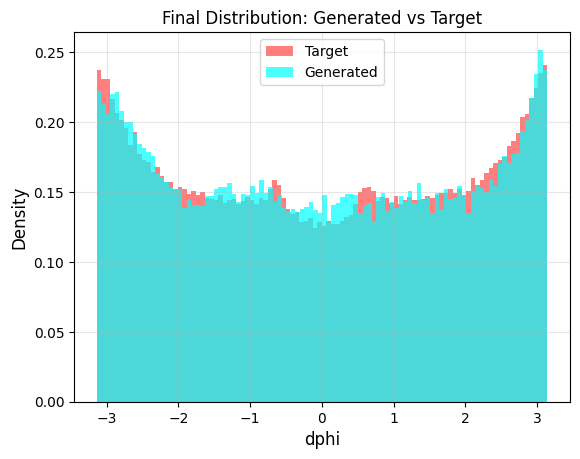

In [10]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

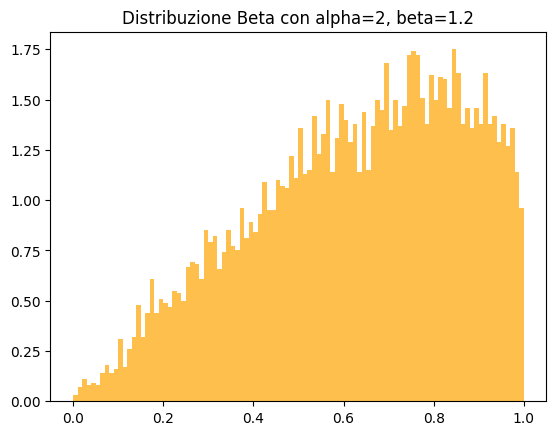

In [26]:
alpha_val = 2
beta_val = 1.2

dist = torch.distributions.Beta(alpha_val, beta_val)
t = dist.sample((10000,))

plt.hist(t.numpy(), bins=100, range=(0,1), density=True, color='orange', alpha=0.7)
plt.title(f"Distribuzione Beta con alpha={alpha_val}, beta={beta_val}")
plt.show()

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 620.34 ms/step | loss    5.900
| iter     10 | 6013.48 ms/step | loss    4.974
| iter     20 | 5992.50 ms/step | loss    5.025
| iter     30 | 6013.13 ms/step | loss    4.985
| iter     40 | 6012.93 ms/step | loss    4.951
| iter     50 | 6020.29 ms/step | loss    4.920
| iter     60 | 5949.47 ms/step | loss    4.950
| iter     70 | 5972.28 ms/step | loss    5.006
| iter     80 | 5910.61 ms/step | loss    4.950
| iter     90 | 5974.59 ms/step | loss    4.901
| iter    100 | 6018.55 ms/step | loss    4.980

Experiment 4 training complete!
Total iterations: 3636


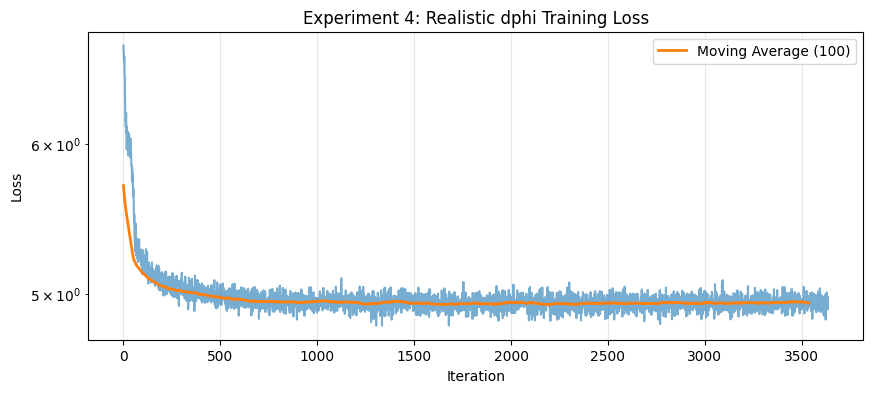

In [27]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

alpha_val = 2
beta_val = 1.2

dist = torch.distributions.Beta(alpha_val, beta_val)

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)

        t = dist.sample((batch_curr,))

        t = t.to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

Generated trajectories shape: (200, 1000000)


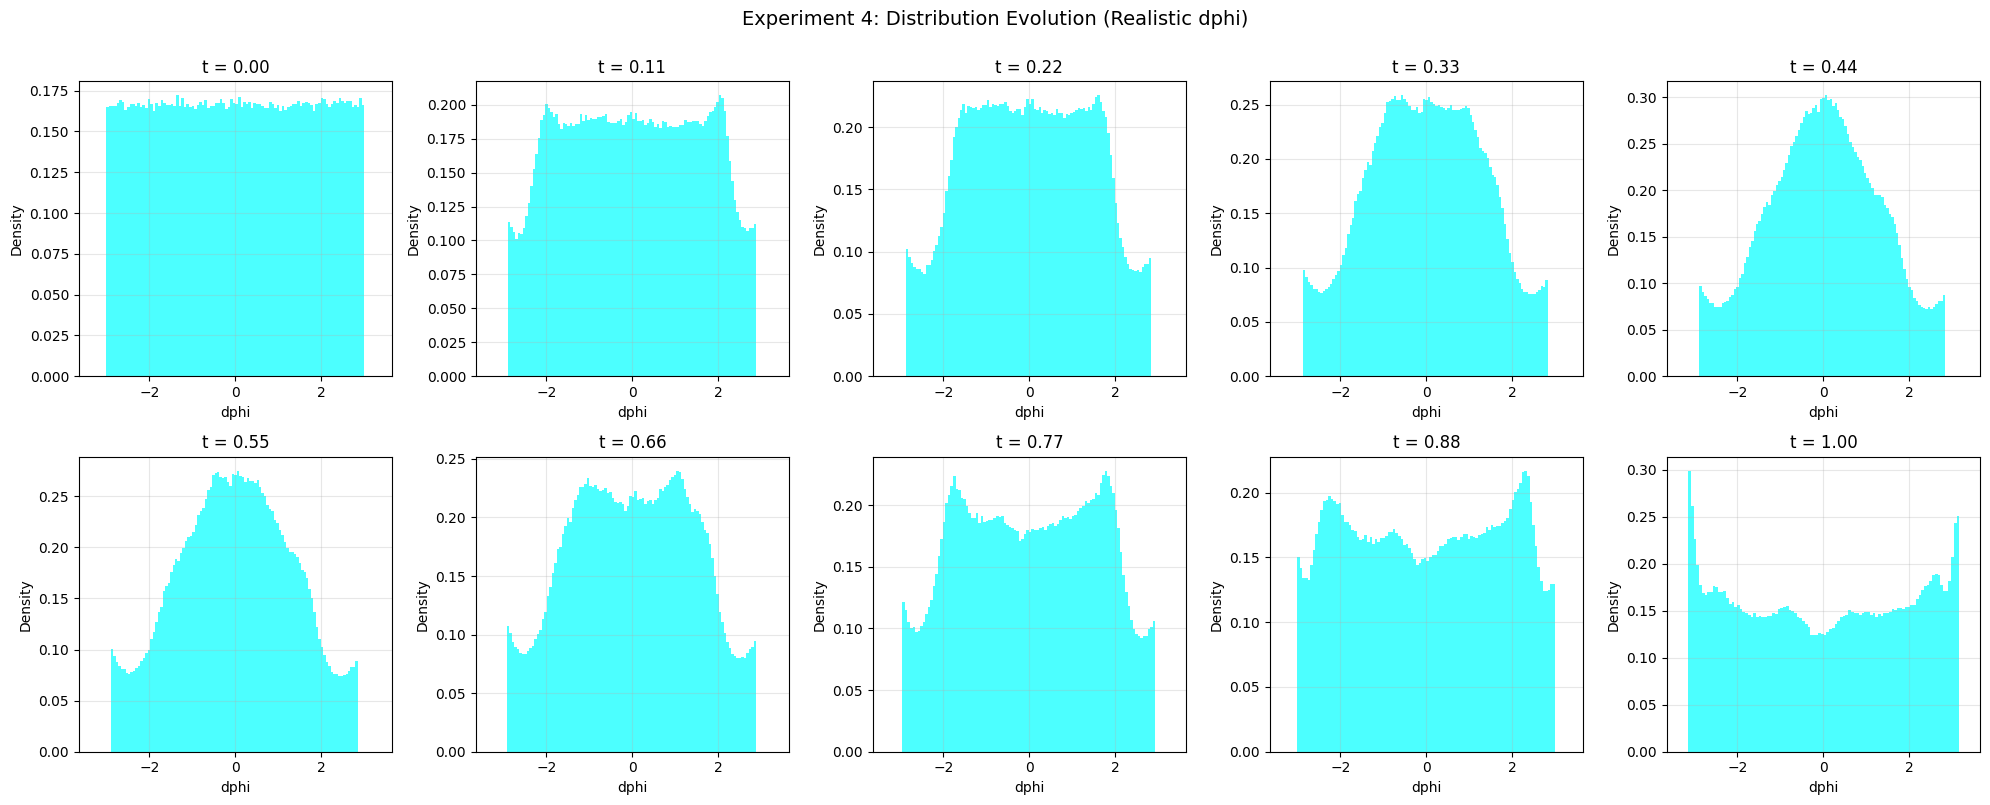

In [ ]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

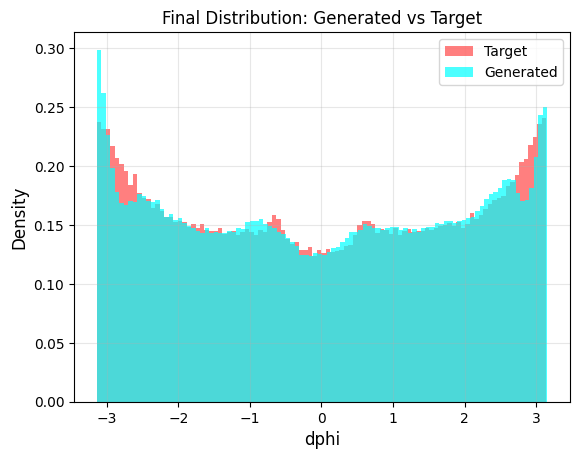

In [31]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Unico batch dopo 2 epoche. Diminuisco il learning rate dopo 100 epoche.

In [11]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 501
bs = 20480
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4_1 = torch.optim.Adam(vf4.parameters(), lr=lr)
optim4_2 = torch.optim.Adam(vf4.parameters(), lr=lr/4)

# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
# loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    if epoch == 0:
        loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
    elif epoch == 2:
        loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True)
    
    if epoch == 0:
        optim4 = optim4_1
    elif epoch == 101:
        optim4 = optim4_2

    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        #t = torch.linspace(0, 1, batch_curr).to(device) # time sampling linearly from [0, 1] (discrete)
        t = torch.rand(batch_curr).to(device) # time sampling randomly from [0, 1] (continuous)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 545.02 ms/step | loss    5.434
| iter     10 | 5140.92 ms/step | loss    5.234
| iter     20 | 5172.21 ms/step | loss    5.237
| iter     30 | 4624.11 ms/step | loss    5.206
| iter     40 | 5308.31 ms/step | loss    5.198
| iter     50 | 5041.44 ms/step | loss    5.187
| iter     60 | 5097.12 ms/step | loss    5.179
| iter     70 | 5118.65 ms/step | loss    5.191
| iter     80 | 5501.39 ms/step | loss    5.188
| iter     90 | 5408.57 ms/step | loss    5.187
| iter    100 | 5379.84 ms/step | loss    5.188
| iter    110 | 5256.58 ms/step | loss    5.193
| iter    120 | 5043.53 ms/step | loss    5.185
| iter    130 | 5074.81 ms/step | loss    5.175
| iter    140 | 5088.49 ms/step | loss    5.185
| iter    150 | 5422.11 ms/step | loss    5.176
| iter    160 | 5349.09 ms/step | loss    5.184
| iter    170 | 5400.95 ms/step | loss    5.181
| iter    180 | 5490.13 ms/step | loss    5.180
| iter    190 | 5323.18 ms/step |

Total iterations: 571


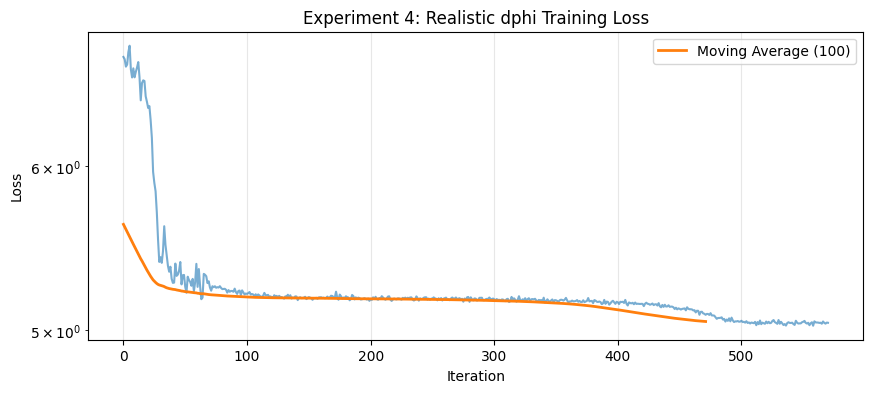

In [12]:
# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

In [13]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

Generated trajectories shape: (200, 100000)


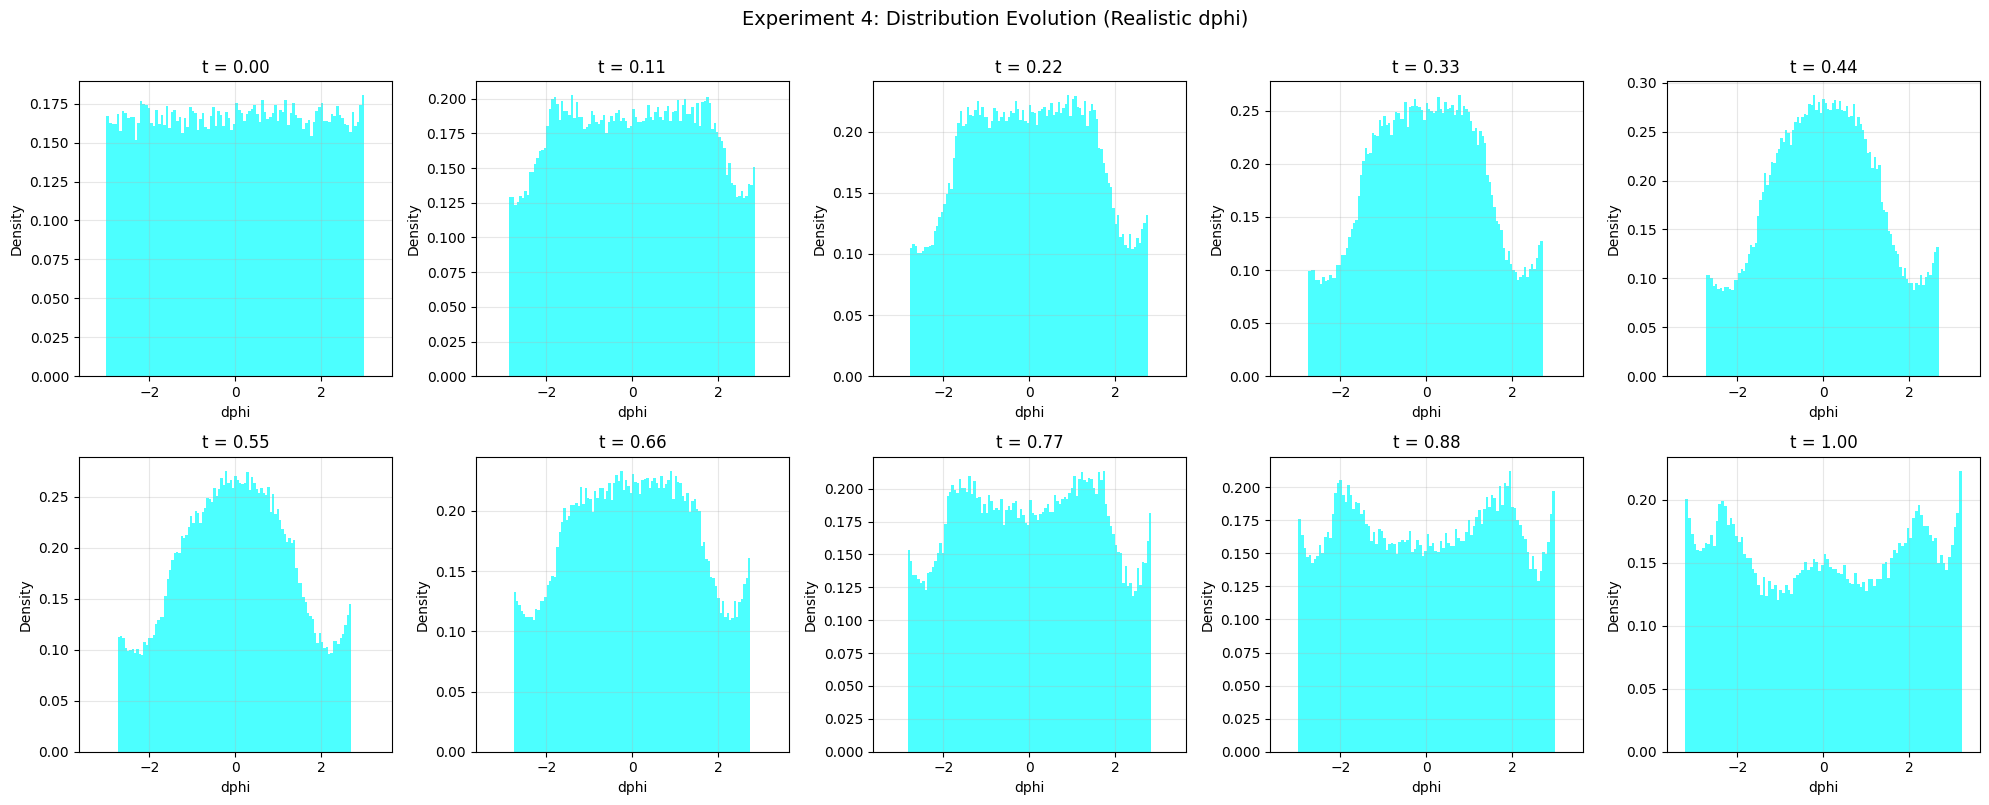

In [14]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

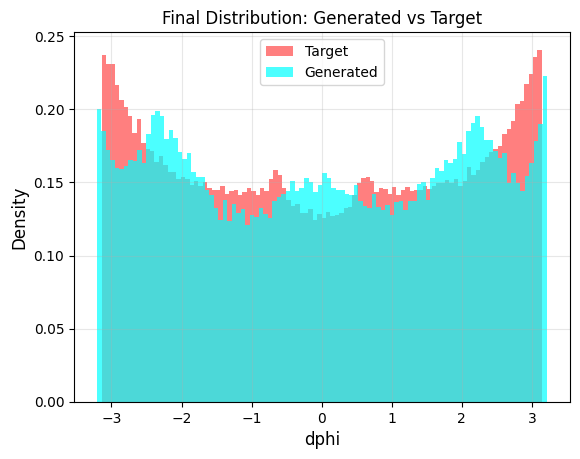

In [15]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

exponential moving avarage -> cambiare learning rate attraverso le epoche

In [ ]:
from torch.optim.swa_utils import AveragedModel, ExponentialMovingAverage

# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 20480
print_every = 10

alpha_val = 2
beta_val = 1.2


vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)

ema_avg = AveragedModel(vf4, multi_avg_fn=ExponentialMovingAverage(beta=0.999))

# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # print(f"Device x_1: {x_1.device}")
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)

        t = torch.rand(batch_curr).to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        ema_avg.update_parameters(vf4)
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

ImportError: cannot import name 'ExponentialMovingAverage' from 'torch.optim.swa_utils' (/home/local/ADUNIPI/i.bini3/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/swa_utils.py)

Provo a cambiare scheduler 
- CosineScheduler() -> Non malissimo, loss altuccia
- VPScheduler() -> Non bene, diverge se t è 0 o 1 , loss alta
- PolynomialConvexScheduler() ->

Using device: cuda
Experiment 4 Model Parameters: 66563
| iter      0 | 625.21 ms/step | loss   18.264
| iter     10 | 5722.53 ms/step | loss   13.703
| iter     20 | 5677.79 ms/step | loss   13.967
| iter     30 | 5739.43 ms/step | loss   13.745
| iter     40 | 5726.76 ms/step | loss   13.980
| iter     50 | 5683.18 ms/step | loss   13.398
| iter     60 | 5674.63 ms/step | loss   13.485
| iter     70 | 5730.12 ms/step | loss   13.469
| iter     80 | 5706.20 ms/step | loss   13.436
| iter     90 | 5723.62 ms/step | loss   13.486
| iter    100 | 5762.60 ms/step | loss   13.532

Experiment 4 training complete!
Total iterations: 1818


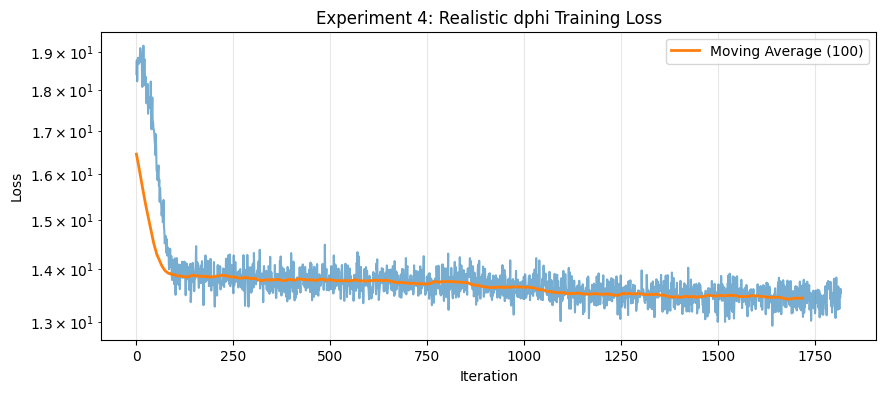

In [30]:
# Initialize new model for dphi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.001
epochs = 101
bs = 40960
print_every = 10

vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
path = AffineProbPath(scheduler=PolynomialConvexScheduler(n=5))
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)

# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")

# start distribution: uniform -3, 3. The range is chosen to cover the dphi data range.
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()

# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)

        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)

        t = torch.rand(batch_curr)# *(1 - 2e-5) + 1e-5 # il range di t sarà tra epsolon e 1-epsilon e non più tra 0 e 1 per evitare problemi numerici
        t = t.to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

    # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 4 training complete!")

# Plot training loss
print(f"Total iterations: {len(losses_exp4)}")
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

In [26]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 200).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

Generated trajectories shape: (200, 100000)


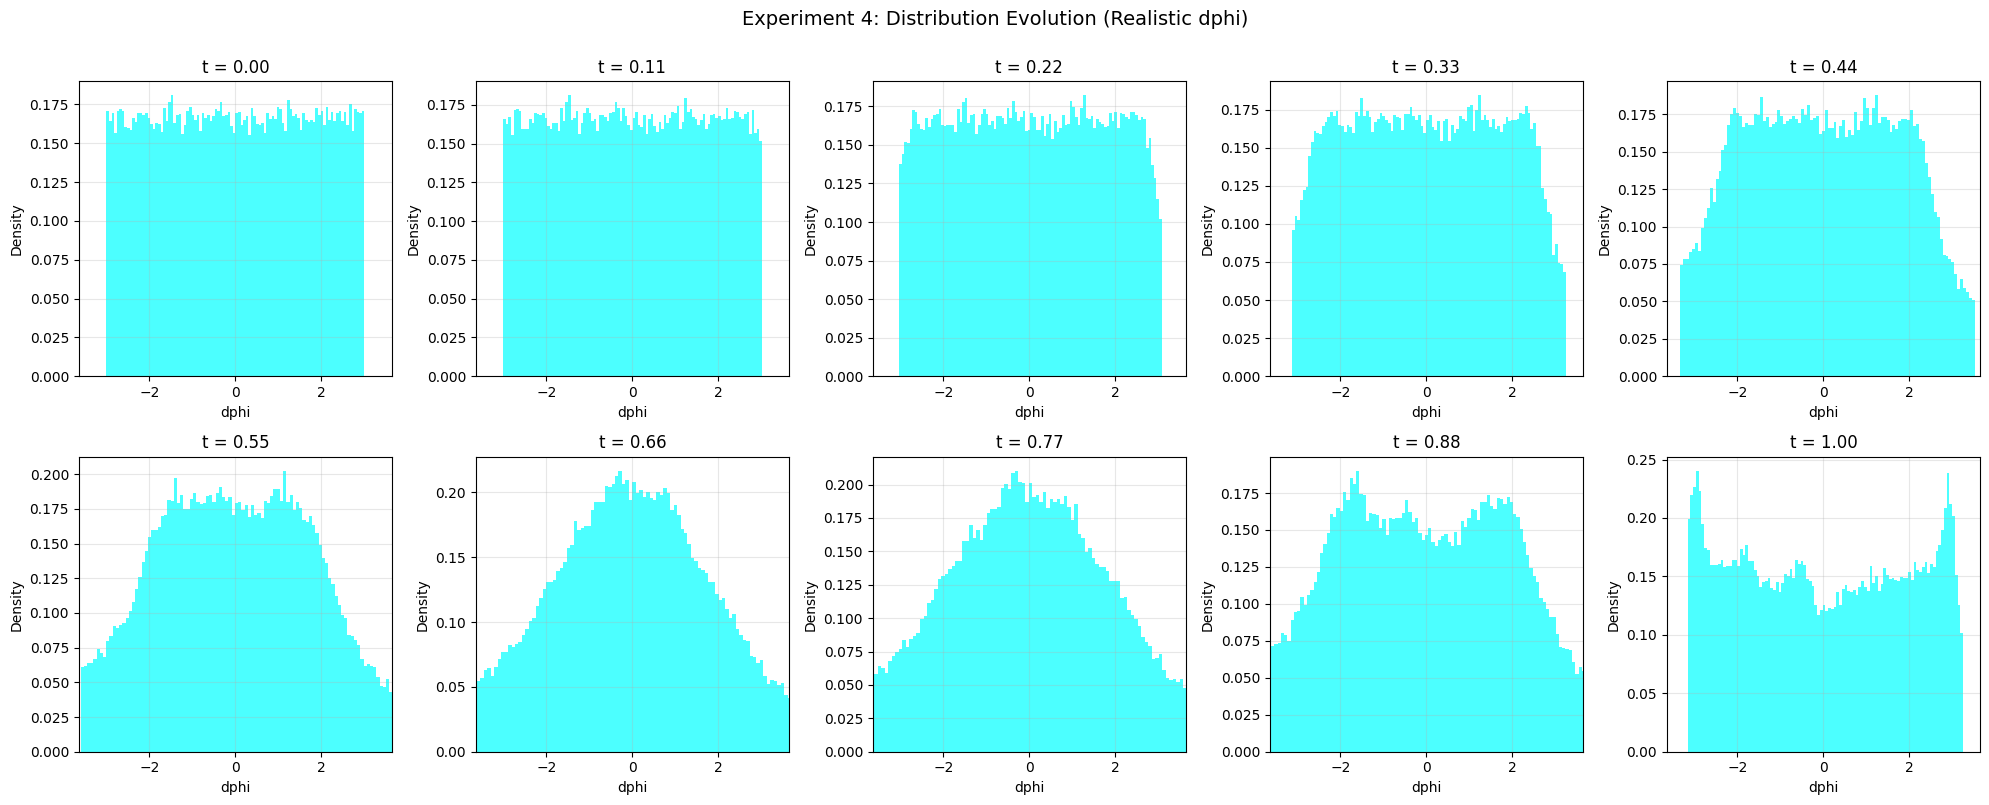

In [27]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

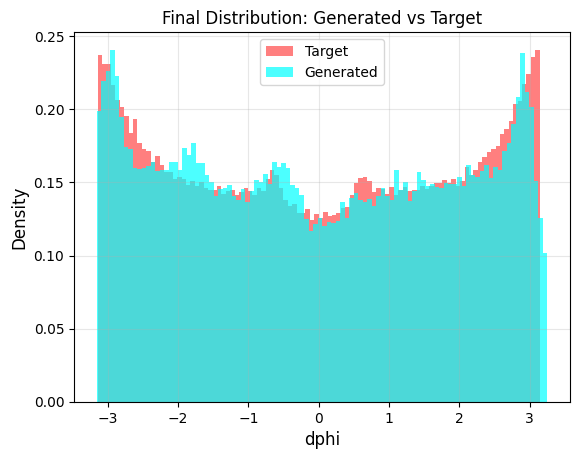

In [28]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()